In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabuary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i +1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# split into training, dev/validation, test split to avoid over fitting and under fitting
# 80%, 10% 10% 

In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    
    X, Y = [], []

    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproductivity
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3 / ((n_embd * block_size) ** 0.5))
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0

# Batch normalization parameters
  
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, b2, W1, b2, bngain, bnbias]

In [79]:
# torch.rand((1, 10))
# just a vectorization practice or play-around.

In [8]:
# number of parameters in total
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12724


In [9]:
Xtr.shape[0]

182625

In [67]:
# let us train  a deeper network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentun update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buggers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__ (self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the NLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # the number of all parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [68]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
# update to data ratio
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors

    # using the custom layer MLP
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # after_debug: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # ===== Deprecated
    # hpreact = embcat @ W1 #+ b1 # hidden layer preactivation

    # # batch norm layers
    # bnmeani = hpreact.mean(0, keepdim=True)
    # bnstdi = hpreact.std(0, keepdim=True)
    # hpreact =  bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # ====== Deprecated

    # ====== Deprecated
    # with torch.no_grad():
    #     bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    #     bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non-linearity
    # h = torch.tanh(hpreact) # hidden layer | activation function
    # logits = h @ W2 + b2 # output layer
    # =========== DEPRECATED
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # =========== DEPRECATED
    # loss = F.cross_entropy(logits, Yb) # loss function
    # print(loss.item())
    
    # backward pass
    # for p in parameters:
    #     p.grad = None
    # loss.backward()

    # ========= Deprecated



    # update
    # lr = lrs[i]
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

# track stats
    if i % 10000 == 0: # modulo to print on every 10k steps along the way
        print(f'{i: 7d}/{max_steps: 7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break

      0/ 200000:  3.2899


layer 2 {      Tanh}: mean -0.01, std 0.63, saturated: 2.78%
layer 5 {      Tanh}: mean -0.00, std 0.63, saturated: 2.75%
layer 8 {      Tanh}: mean -0.00, std 0.64, saturated: 2.72%
layer 11 {      Tanh}: mean -0.00, std 0.64, saturated: 2.47%
layer 14 {      Tanh}: mean +0.00, std 0.64, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

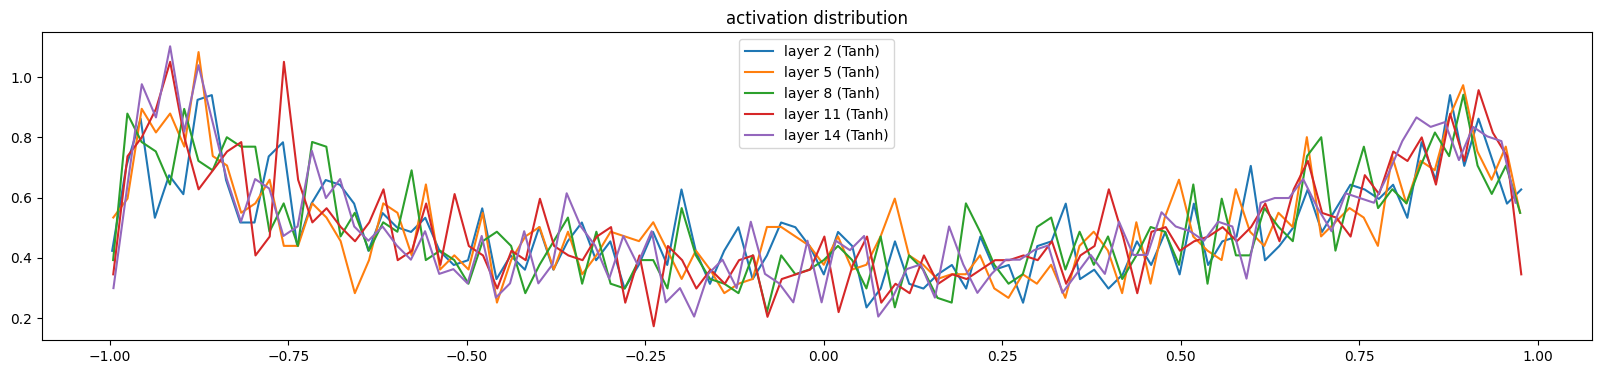

In [69]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output or last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d {%10s}: mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 {      Tanh}: mean +0.00, std 4.262872e-03 
layer 5 {      Tanh}: mean +0.00, std 3.545727e-03 
layer 8 {      Tanh}: mean +0.00, std 3.231292e-03 
layer 11 {      Tanh}: mean +0.00, std 2.943103e-03 
layer 14 {      Tanh}: mean +0.00, std 3.042317e-03 


Text(0.5, 1.0, 'gradient distribution')

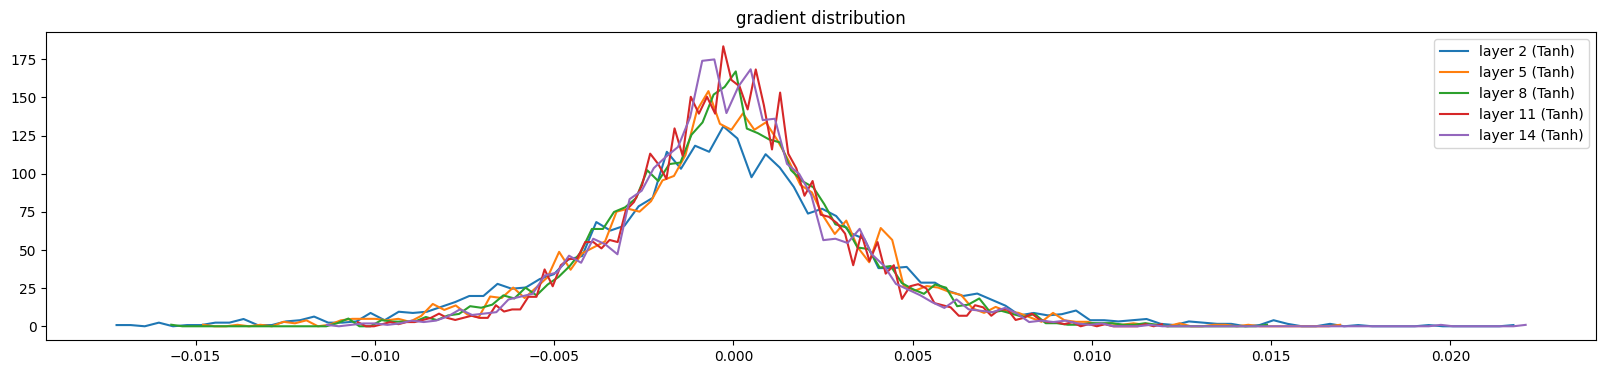

In [70]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output or last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d {%10s}: mean %+.2f, std %e ' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

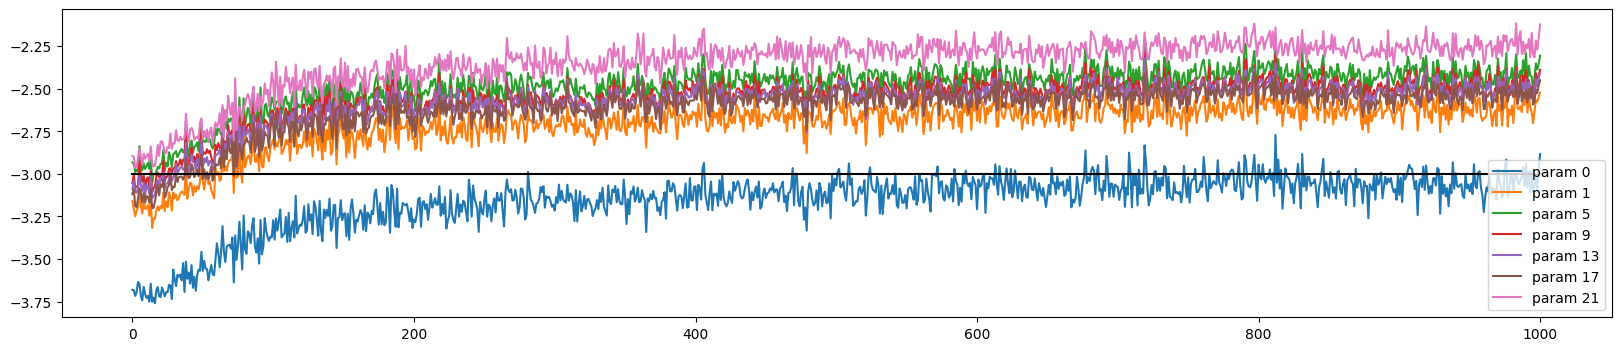

In [71]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
# torch.tensor(ud).shape

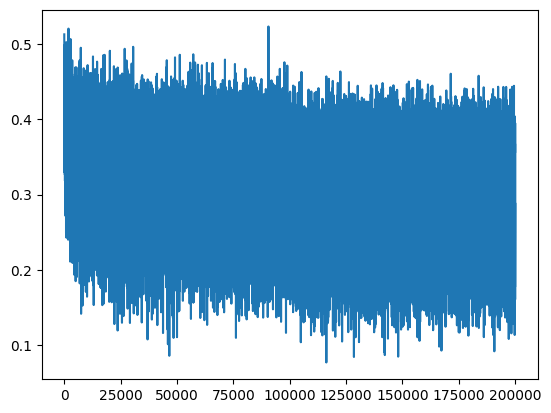

In [18]:
# plt.plot(lossi)
# softmax confidence test

In [107]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_Size * n_ebmd)
    hpreact = embcat @ W1  #+ b1 # hidden layer preactivation
    hpreact =  bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.133599281311035
val 2.158169984817505


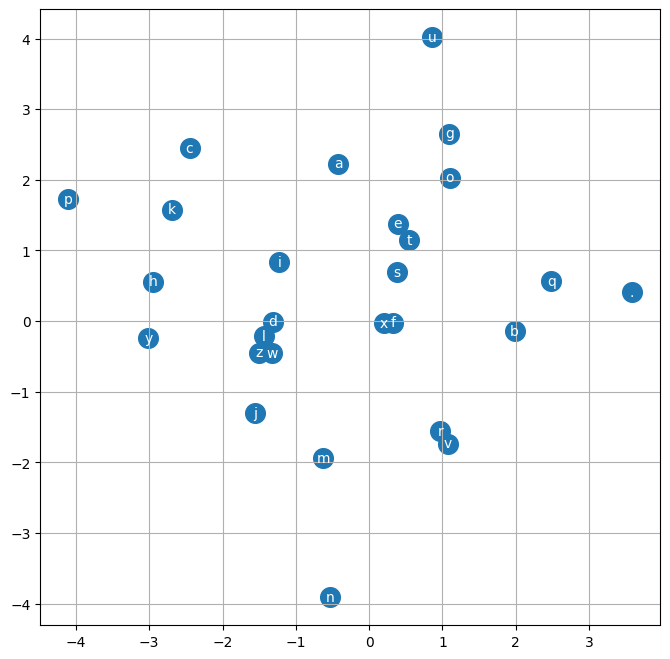

In [71]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [26]:
# sample from the network
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range (20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

montalmyazhiee.
mad.
ryah.
rethruttadrari.
aderedielin.
shi.
jenleigh.
edora.
raelyn.
malke.
cayshaberghai.
jest.
jair.
jelionntton.
kue.
kavdi.
jamelizek.
yule.
mystouda.
halina.


In [ ]:
# let us infer a minibatch to save the NN from taking on too much at a time

torch.randint(0, X.shape[0], (32,)).shape

torch.Size([32])

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([1.5988, 4.2595, 2.1688, 2.0830, 2.2983, 1.9719, 1.5988, 1.7469, 2.0649,
        1.7365, 2.1566, 1.6348, 2.9471, 1.9044, 3.0296, 1.8141, 1.7365, 1.5003,
        1.9932, 2.2448, 2.0914, 2.3320, 2.2010, 1.9666, 2.6070, 2.1784, 2.0046,
        2.1909, 1.7365, 1.7365, 1.8599, 1.6266], grad_fn=<MaxBackward0>),
indices=tensor([12, 12,  1,  5,  0,  5, 12,  0,  1,  1,  0, 12,  0,  1,  5,  0,  1, 12,
         5,  0,  0,  5,  0,  5,  0,  5,  1,  1,  1,  1,  0,  5]))